In [2]:
# import Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from itertools import chain
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score,KFold
from sklearn.svm import LinearSVC, SVC
import warnings
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

warnings.filterwarnings('ignore') #ignore warning messages

In [3]:
# Define Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Reds) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Show metrics 
def show_metrics(cm):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Accuracy  =     {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('Precision =     {:.3f}'.format(tp/(tp+fp)))
    print('Recall    =     {:.3f}'.format(tp/(tp+fn)))
    print('F1_score  =     {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/
                                                 ((tp/(tp+fp))+(tp/(tp+fn))))))
# Define Precision-recall curve
def plot_precision_recall():
    plt.step(recall, precision, color = 'b', alpha = 0.2,
             where = 'post')
    plt.fill_between(recall, precision, step ='post', alpha = 0.2,
                 color = 'b')

    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0,1])
    plt.ylim([0.0,1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show();
# Define ROC curve
def plot_roc():
    plt.plot(fpr, tpr, label = 'ROC curve', linewidth = 2)
    plt.plot([0,1],[0,1], 'r--', linewidth = 2)
   # plt.xlim([0.0,0.001])
   # plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show();
#Define Learning curve
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    """
    Plots a learning curve. http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "b",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    return plt
# Define cross-validation metrics
def cross_val_metrics(model, X, y) :
    scores = ['f1','accuracy', 'precision', 'recall']
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = kf, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))


#Define output results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def test_network(clf, X_test, y_test):
  pred = clf.predict(X_test)
  clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
  print("Test Result:\n================================================")        
  print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
  print("_______________________________________________")
  print(f"CLASSIFICATION REPORT:\n{clf_report}")
  print("_______________________________________________")
  print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Prepare training, validation and testing data sets.

In [4]:
from google.colab import drive
drive.mount('/content/drive')
# Read training data
train_data = pd.read_csv("/content/drive/MyDrive/Data/BREAST-CANCER-TRAIN-R.csv")
# Drop the ID feature
train_data = train_data.drop('ID', 1)
# We found there are some missing values in the data
train_data = train_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
print(train_data.isnull().sum())
modifiedDf = train_data.dropna() # Remove rows with empty values
print(modifiedDf.isnull().sum())
modifiedDf.dtypes

Mounted at /content/drive
CLUMP          0
CELL_SIZE      0
CELL_SHAPE     0
ADHESION       0
EPITHELIAL     0
BARE          11
BLAND          0
NORMAL         0
MITOSIS        0
CLASS          0
dtype: int64
CLUMP         0
CELL_SIZE     0
CELL_SHAPE    0
ADHESION      0
EPITHELIAL    0
BARE          0
BLAND         0
NORMAL        0
MITOSIS       0
CLASS         0
dtype: int64


CLUMP          int64
CELL_SIZE      int64
CELL_SHAPE     int64
ADHESION       int64
EPITHELIAL     int64
BARE          object
BLAND          int64
NORMAL         int64
MITOSIS        int64
CLASS          int64
dtype: object

In [5]:
modifiedDf['BARE'] = pd.to_numeric(modifiedDf['BARE'])
modifiedDf.dtypes
modifiedDf.shape

(406, 10)

In [6]:
modifiedDf['CLASS'].replace(2,0,inplace = True)
modifiedDf['CLASS'].replace(4,1,inplace = True)
modifiedDf[['CLASS']].head()

,CLASS
0,0
1,0
2,0
3,0
4,0


In [7]:
from scipy.ndimage.measurements import mean
#Prepare train dataset
# Define X(features) and Y(diagnosis(0 or 1))
y_data = modifiedDf['CLASS']
x_data = modifiedDf.drop('CLASS', 1).reset_index(drop=True)
col = modifiedDf.columns
#Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_data = sc.fit_transform(x_data)
x_data = pd.DataFrame(x_data,columns = col[:-1])
y_data.reset_index(drop= True,inplace = True)
x_data
#exclude outliers
join = pd.concat([x_data,y_data],axis = 1)
join = join[join['MITOSIS']<=4]
y_data = join['CLASS']
x_data = join.drop('CLASS', 1).reset_index(drop=True)

In [8]:
#Data collinearity test
from statsmodels.stats.outliers_influence import variance_inflation_factor
variance_inflation_factor(x_data.values, 1)

7.694241775830329

VIF>5, there is severe multicollinearity.

In [9]:
x_data_withoutshape = x_data.drop('CELL_SHAPE',1)
variance_inflation_factor(x_data_withoutshape.values, 1)

4.2550446985311545

single factor checking

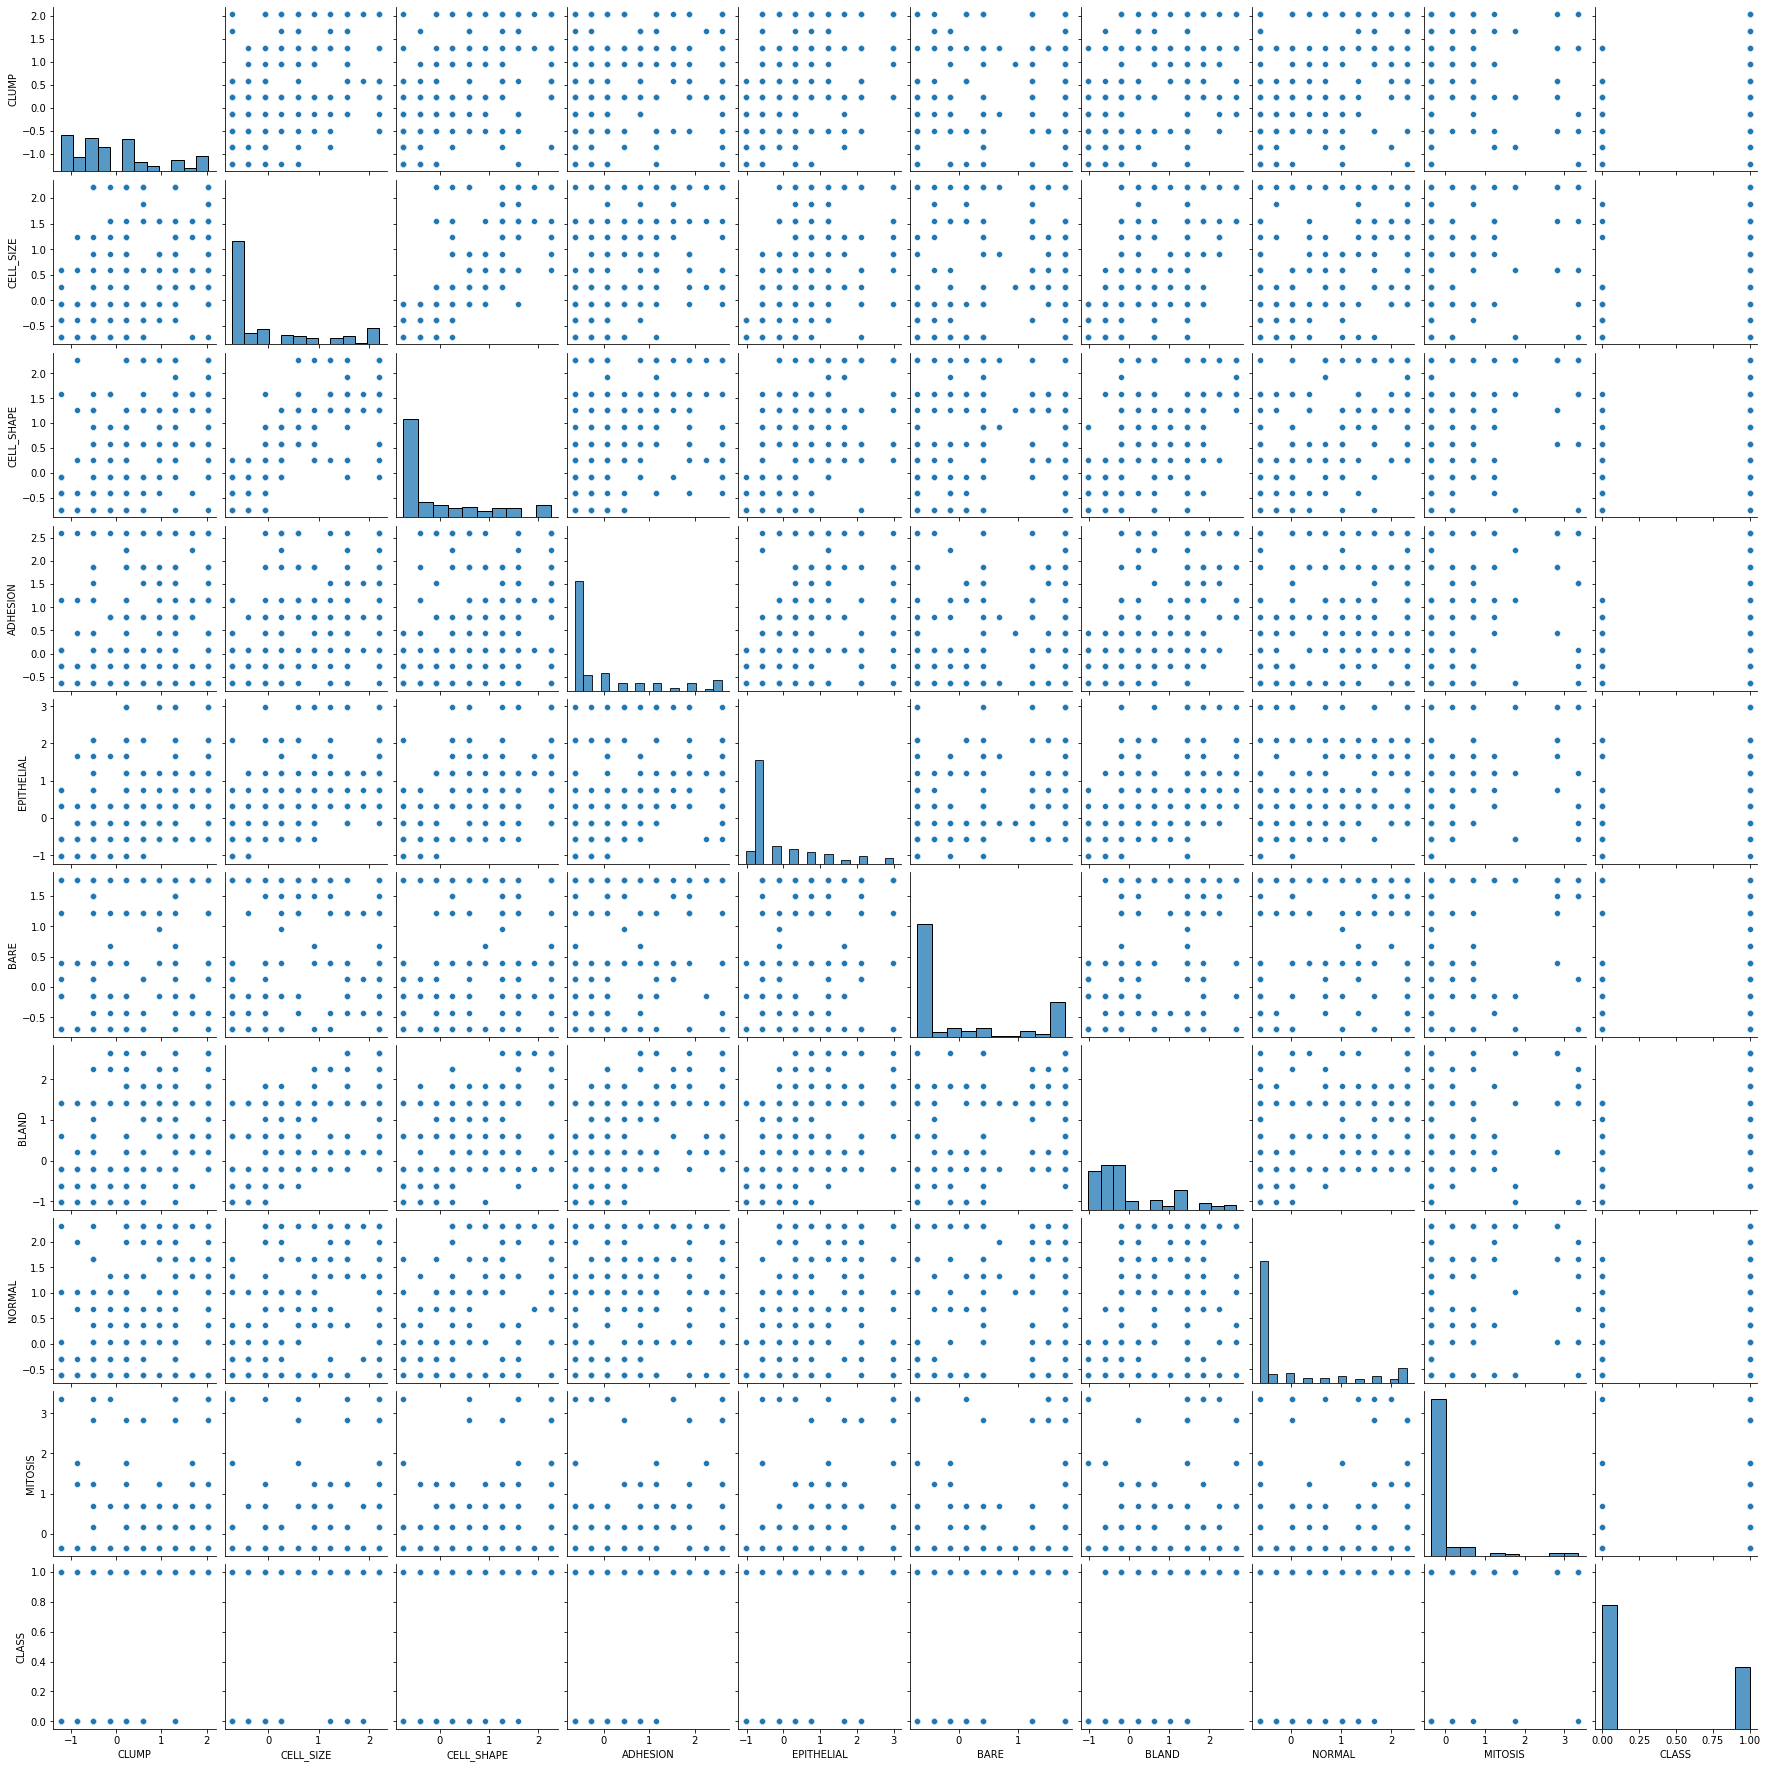

In [10]:
sns.pairplot(join)

# Support Vector Machine

In [11]:
# Kfold validation on SVM model using all 9 features
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
linear_kernel_SVM1 = SVC(gamma='auto', kernel='linear', probability=True)
linear_kernel_SVM1.fit(x_data,y_data)
cross_val_metrics(linear_kernel_SVM1, x_data, y_data)

[f1] : 0.94572 (+/- 0.02141)
[accuracy] : 0.96206 (+/- 0.01795)
[precision] : 0.93862 (+/- 0.05483)
[recall] : 0.95602 (+/- 0.02701)


In [12]:
# Kfold validation on SVM model using 8 features(without cell_shape)
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
linear_kernel_SVM2 = SVC(gamma='auto', kernel='linear', probability=True)
linear_kernel_SVM2.fit(x_data_withoutshape,y_data)
cross_val_metrics(linear_kernel_SVM2, x_data_withoutshape, y_data)

[f1] : 0.94963 (+/- 0.02157)
[accuracy] : 0.96459 (+/- 0.01864)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.95602 (+/- 0.02701)


In [13]:
# Kfold validation on non-linear SVM model using all 9 features
param_grid = {'gamma':np.linspace(0.0001,1,20),
              'C': np.arange(0,2.5,0.25),
              'kernel':['rbf']}
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
svm_nonlinear1 = SVC(probability= True)
grid_svm_nonlinear1 = GridSearchCV(estimator = svm_nonlinear1, param_grid = param_grid,scoring = 'recall', cv=kf,
                    n_jobs = -1)
grid_svm_nonlinear1.fit(x_data, y_data)
best_parameters1 = grid_svm_nonlinear1.best_params_
best_scores1 = grid_svm_nonlinear1.best_score_
print('The best parameters for using this model is', best_parameters1)
print('The best scores for using this model is', best_scores1)

The best parameters for using this model is {'C': 0.25, 'gamma': 0.7894947368421052, 'kernel': 'rbf'}
The best scores for using this model is 0.99375


In [14]:
# Kfold validation on non-linear SVM model using 8 features(without cell_shape)
param_grid = {'gamma':np.linspace(0.0001,1,20),
              'C': np.arange(0,2.5,0.25),
              'kernel':['rbf']}
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
svm_nonlinear2 = SVC(probability= True)
grid_svm_nonlinear2 = GridSearchCV(estimator = svm_nonlinear2, param_grid = param_grid,scoring = 'recall', cv=kf,
                     n_jobs = -1)
grid_svm_nonlinear2.fit(x_data_withoutshape, y_data)
best_parameters2 = grid_svm_nonlinear2.best_params_
best_scores2 = grid_svm_nonlinear2.best_score_
print('The best parameters for using this model is', best_parameters2)
print('The best scores for using this model is', best_scores2)

The best parameters for using this model is {'C': 0.25, 'gamma': 0.7894947368421052, 'kernel': 'rbf'}
The best scores for using this model is 0.99375


In [15]:
# SVM Confusion matrix on all training data
svm = SVC(**grid_svm_nonlinear2.best_params_,probability= True)
svm.fit(x_data_withoutshape, y_data)
y_pred = svm.predict(x_data_withoutshape)
y_pred_probs = svm.predict_proba(x_data_withoutshape)[:,1]
cross_val_metrics(svm, x_data, y_data)

[f1] : 0.91595 (+/- 0.04885)
[accuracy] : 0.93674 (+/- 0.03759)
[precision] : 0.85335 (+/- 0.08346)
[recall] : 0.99375 (+/- 0.01250)


In [16]:
test_network(svm, x_data_withoutshape, y_data)

Test Result:
Accuracy Score: 94.19%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    1.000000    0.851613  0.941919    0.925806      0.950538
recall       0.912879    1.000000  0.941919    0.956439      0.941919
f1-score     0.954455    0.919861  0.941919    0.937158      0.942924
support    264.000000  132.000000  0.941919  396.000000    396.000000
_______________________________________________
Confusion Matrix: 
 [[241  23]
 [  0 132]]



There is no obvious difference in terms of model performance between using all 9 features and 8 features(without cell_shape). In order to better comparing the other models, we use 8 features.
Compared with SVC model, SVM model has lower accuracy but higher recall(99.37%). In the breast cancer case, we think recall is more important  because we do not want misclassify any true malignant tumors.

# KNN

[0.9120476190476191, 0.8715424430641822, 0.9351904761904762, 0.9280476190476191, 0.9497738095238095, 0.9497738095238095, 0.9497738095238095, 0.9497738095238095, 0.9560238095238095, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763]
[0.9519620253164558, 0.9469620253164557, 0.9595569620253164, 0.9595569620253166, 0.967120253164557, 0.967120253164557, 0.967120253164557, 0.967120253164557, 0.9696518987341772, 0.9671518987341772, 0.

Text(0.5, 1.0, 'KNN1 on breast cancer data')

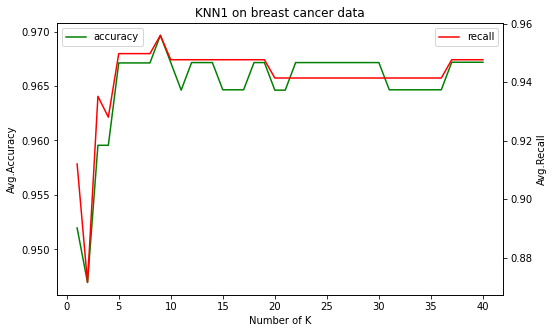

In [17]:
# Kfold validation on KNN model using all 9 features
from sklearn.neighbors import KNeighborsClassifier
recall = []
accuracy = []
for k in range(1,41):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  knn1 = KNeighborsClassifier(n_neighbors =k)
  knn1.fit(x_data, y_data)
  recall.append(cross_val_score(knn1, x_data, y_data, scoring='recall', cv=kf, n_jobs=-1).mean())
  accuracy.append(cross_val_score(knn1, x_data, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean())
print(recall)
print(accuracy)
print("Maximum accuracy:",max(accuracy),"at K =",accuracy.index(max(accuracy))+1)
print("Maximum recall:",max(recall),"at K =",recall.index(max(recall))+1)
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(range(1,41),accuracy,color = 'g',label = 'accuracy')
ax1.set_ylabel('Avg.Accuracy')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(range(1,41),recall,color = 'r',label = 'recall')
ax2.set_ylabel('Avg.Recall')
ax2.legend(loc = 'upper right')
ax1.set(xlabel = 'Number of K')
plt.title('KNN1 on breast cancer data')

[0.8971309523809523, 0.8645967908902691, 0.9289404761904763, 0.9217976190476191, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9414404761904762, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9476904761904763, 0.9414404761904762]
[0.9469620253164557, 0.9444303797468354, 0.9544936708860761, 0.9570253164556963, 0.9646202531645569, 0.9646202531645569, 0.9620886075949366, 0.9646202531645569, 0.9646202531645569, 0.9646202531645569

Text(0.5, 1.0, 'KNN2 on breast cancer data')

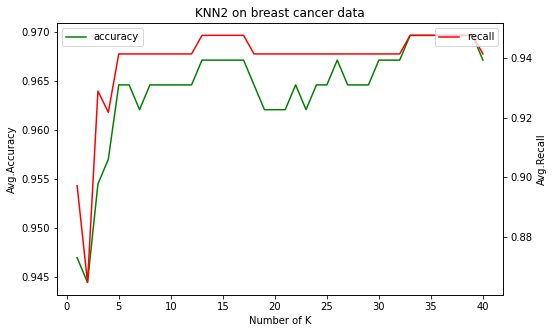

In [18]:
# Kfold validation on KNN model using 8 features
from sklearn.neighbors import KNeighborsClassifier
recall = []
accuracy = []
for k in range(1,41):
  kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
  knn2 = KNeighborsClassifier(n_neighbors =k)
  knn2.fit(x_data_withoutshape, y_data)
  recall.append(cross_val_score(knn2, x_data_withoutshape, y_data, scoring='recall', cv=kf, n_jobs=-1).mean())
  accuracy.append(cross_val_score(knn2, x_data_withoutshape, y_data, scoring='accuracy', cv=kf, n_jobs=-1).mean())
print(recall)
print(accuracy)
print("Maximum accuracy:",max(accuracy),"at K =",accuracy.index(max(accuracy))+1)
print("Maximum recall:",max(recall),"at K =",recall.index(max(recall))+1)
fig,ax1 = plt.subplots(figsize=(8,5))
ax1.plot(range(1,41),accuracy,color = 'g',label = 'accuracy')
ax1.set_ylabel('Avg.Accuracy')
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()
ax2.plot(range(1,41),recall,color = 'r',label = 'recall')
ax2.set_ylabel('Avg.Recall')
ax2.legend(loc = 'upper right')
ax1.set(xlabel = 'Number of K')
plt.title('KNN2 on breast cancer data')

In [19]:
# KNN Confusion matrix on all training data
knn = KNeighborsClassifier(n_neighbors =9)
knn.fit(x_data, y_data)
cross_val_metrics(knn, x_data, y_data)

[f1] : 0.95686 (+/- 0.02000)
[accuracy] : 0.96965 (+/- 0.01720)
[precision] : 0.95917 (+/- 0.03822)
[recall] : 0.95602 (+/- 0.02701)


In [20]:
test_network(knn, x_data, y_data)

Test Result:
Accuracy Score: 97.22%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.980989    0.954887  0.972222    0.967938      0.972288
recall       0.977273    0.962121  0.972222    0.969697      0.972222
f1-score     0.979127    0.958491  0.972222    0.968809      0.972248
support    264.000000  132.000000  0.972222  396.000000    396.000000
_______________________________________________
Confusion Matrix: 
 [[258   6]
 [  5 127]]



#Logistic Regression

In [21]:
CV_log_clf = LogisticRegression()
CV_log_clf.fit(x_data_withoutshape, y_data)

LogisticRegression()

In [22]:
cross_val_metrics(CV_log_clf, x_data_withoutshape, y_data)

[f1] : 0.94519 (+/- 0.01691)
[accuracy] : 0.96209 (+/- 0.01606)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.94769 (+/- 0.03113)


In [23]:
y_data = pd.DataFrame(y_data)
y_data=y_data.reset_index(drop=True)


In [24]:
import statsmodels.api as sm
x_data_withoutshape1 = sm.add_constant(x_data_withoutshape)
log_reg = sm.Logit(y_data,x_data_withoutshape1)
clf_1 = log_reg.fit()
print(clf_1.summary())

result = clf_1.conf_int(0.05)
result['Coefficient'] =clf_1.params
result['SE'] = clf_1.bse
result['Lower probabilities'] = np.exp(result[0])/(1+np.exp(result[0]))
result['Upper probabilities'] = np.exp(result[1])/(1+np.exp(result[1]))
result.drop([0,1],inplace=True,axis =1)
print(result)


Optimization terminated successfully.
         Current function value: 0.076270
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  CLASS   No. Observations:                  396
Model:                          Logit   Df Residuals:                      387
Method:                           MLE   Df Model:                            8
Date:                Sun, 04 Dec 2022   Pseudo R-squ.:                  0.8802
Time:                        19:17:43   Log-Likelihood:                -30.203
converged:                       True   LL-Null:                       -252.06
Covariance Type:            nonrobust   LLR p-value:                 8.218e-91
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0759      0.423     -2.543      0.011      -1.905      -0.247
CLUMP          1.6233      0

# LDA

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='svd')
LDA = lda.fit(x_data_withoutshape, y_data)
cross_val_metrics(LDA, x_data_withoutshape, y_data)

[f1] : 0.94905 (+/- 0.02076)
[accuracy] : 0.96462 (+/- 0.01864)
[precision] : 0.95876 (+/- 0.03846)
[recall] : 0.94144 (+/- 0.03539)


#L1 regression

In [26]:
# ploynomials, degree = 3
from sklearn.preprocessing import PolynomialFeatures
poly_3 = PolynomialFeatures(degree = 3,include_bias=False)
X_poly_3 = poly_3.fit_transform(x_data_withoutshape)

log_clf = LogisticRegression(random_state = 42)
lr_3 = LogisticRegression(penalty = 'l1', C = 0.05, solver = 'liblinear')
lr_3.fit(X_poly_3, y_data)

cross_val_metrics(lr_3, X_poly_3, y_data)

[f1] : 0.95388 (+/- 0.02473)
[accuracy] : 0.96712 (+/- 0.02060)
[precision] : 0.95150 (+/- 0.04134)
[recall] : 0.96402 (+/- 0.02023)


In [27]:
coef = pd.DataFrame(lr_3.coef_[0],poly_3.get_feature_names(x_data_withoutshape.columns))
coef.reset_index(inplace =True)
coef.columns = ['Feature','coef']
coef.sort_values(by = 'coef',ascending= False,inplace = True)
coef = coef.loc[coef['coef']>0].reset_index(drop=True)
coef

,Feature,coef
0,BARE,0.937581
1,CLUMP^3,0.403901
2,BLAND^3,0.211985
3,NORMAL^3,0.191635
4,CELL_SIZE,0.174549
5,ADHESION^3,0.152641
6,BARE^3,0.060748
7,EPITHELIAL^3,0.051584


Text(0, 0.5, 'Coefficient')

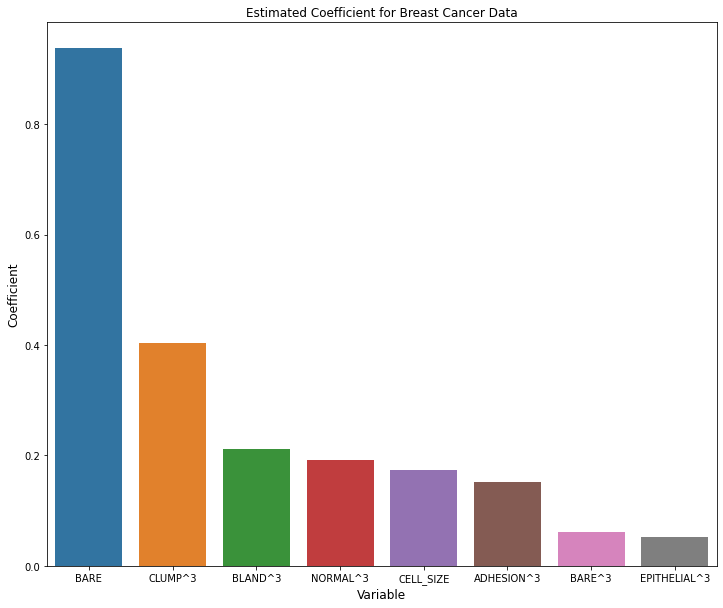

In [28]:
variable =coef.Feature
coefficient = coef.coef
fig,(ax) = plt.subplots( figsize = (12,10))
sns.barplot(x=variable, y= coefficient, ax=ax)
ax.set_title('Estimated Coefficient for Breast Cancer Data')
ax.set_xlabel('Variable', fontsize=12)
ax.set_ylabel('Coefficient', fontsize=12)

# Ensemble model

In [29]:
#Voting Classifier
voting_clf = VotingClassifier (
        estimators = [('SVM', svm), ('knn', knn)],
                     voting='soft', weights = [1, 1])
    
voting_clf.fit(x_data_withoutshape,y_data)

y_pred = voting_clf.predict(x_data_withoutshape)
y_score = voting_clf.predict_proba(x_data_withoutshape)[:,1]

cross_val_metrics(voting_clf, x_data_withoutshape, y_data)

[f1] : 0.94627 (+/- 0.02644)
[accuracy] : 0.96206 (+/- 0.02122)
[precision] : 0.92555 (+/- 0.05530)
[recall] : 0.97027 (+/- 0.01530)


# Compare all models

In [30]:
print('SVC:')
cross_val_metrics(linear_kernel_SVM2, x_data_withoutshape, y_data)
print('Nonlinear SVM:')
cross_val_metrics(svm, x_data_withoutshape, y_data)
print('KNN:')
cross_val_metrics(knn, x_data, y_data)
print('Voting Classfier:')
cross_val_metrics(voting_clf, x_data_withoutshape, y_data)
print('Logistic Regression:')
cross_val_metrics(CV_log_clf, x_data_withoutshape, y_data)
print('LDA:')
cross_val_metrics(LDA, x_data_withoutshape, y_data)
print('Polynomial Regression with L1 regularization:')
cross_val_metrics(lr_3, X_poly_3, y_data)

SVC:
[f1] : 0.94963 (+/- 0.02157)
[accuracy] : 0.96459 (+/- 0.01864)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.95602 (+/- 0.02701)
Nonlinear SVM:
[f1] : 0.91873 (+/- 0.04679)
[accuracy] : 0.93927 (+/- 0.03530)
[precision] : 0.85779 (+/- 0.07983)
[recall] : 0.99375 (+/- 0.01250)
KNN:
[f1] : 0.95686 (+/- 0.02000)
[accuracy] : 0.96965 (+/- 0.01720)
[precision] : 0.95917 (+/- 0.03822)
[recall] : 0.95602 (+/- 0.02701)
Voting Classfier:
[f1] : 0.94627 (+/- 0.02644)
[accuracy] : 0.96206 (+/- 0.02122)
[precision] : 0.92555 (+/- 0.05530)
[recall] : 0.96402 (+/- 0.02023)
Logistic Regression:
[f1] : 0.94519 (+/- 0.01691)
[accuracy] : 0.96209 (+/- 0.01606)
[precision] : 0.94569 (+/- 0.04942)
[recall] : 0.94769 (+/- 0.03113)
LDA:
[f1] : 0.94905 (+/- 0.02076)
[accuracy] : 0.96462 (+/- 0.01864)
[precision] : 0.95876 (+/- 0.03846)
[recall] : 0.94144 (+/- 0.03539)
Polynomial Regression with L1 regularization:
[f1] : 0.95388 (+/- 0.02473)
[accuracy] : 0.97218 (+/- 0.01863)
[precision] : 0.95150 (

# Predict

In [31]:
# Read test data
test_data = pd.read_csv("/content/drive/MyDrive/Data/BREAST-CANCER-TESTR-W.csv")
# Drop the ID feature
test_data = test_data.drop('ID', 1)
# Print the first 5 examples
test_data.head()

,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS,CLASS
0,3,1,1,1,2,2,3,1,1,
1,8,10,10,8,7,10,9,7,1,
2,5,3,3,3,2,3,4,4,1,
3,8,7,5,10,7,9,5,5,4,
4,7,4,6,4,6,1,4,3,1,


In [32]:
#Prepare test dataset
test_data = test_data.drop('CLASS', 1)
test_data = test_data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
test_data['BARE'].fillna(test_data['BARE'].median(),inplace = True) # fill the space with median
test_data['BARE'] = pd.to_numeric(test_data['BARE'])

X_test = np.array(test_data.values)
# standardize the test data using defined sc
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = test_data.columns)
X_test_scaled = X_test_scaled.drop('CELL_SHAPE',1)

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 3,include_bias=False)
x_poly = poly.fit_transform(X_test_scaled)
y_test = lr_3.predict(x_poly)
test_data['CLASS'] = y_test
test_data['CLASS'].replace(0,2,inplace = True)
test_data['CLASS'].replace(1,4,inplace = True)
test_data.to_csv('/content/drive/MyDrive/Data/BREAST-CANCER-TESTR.csv')
test_data


,CLUMP,CELL_SIZE,CELL_SHAPE,ADHESION,EPITHELIAL,BARE,BLAND,NORMAL,MITOSIS,CLASS
0,3,1,1,1,2,2.0,3,1,1,2
1,8,10,10,8,7,10.0,9,7,1,4
2,5,3,3,3,2,3.0,4,4,1,2
3,8,7,5,10,7,9.0,5,5,4,4
4,7,4,6,4,6,1.0,4,3,1,2
...,...,...,...,...,...,...,...,...,...,...
277,5,10,10,10,4,10.0,5,6,3,4
278,1,1,1,1,2,1.0,1,1,1,2
279,5,10,10,5,4,5.0,4,4,1,2
280,3,1,1,1,3,2.0,1,1,1,2
